In [15]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import psutil
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

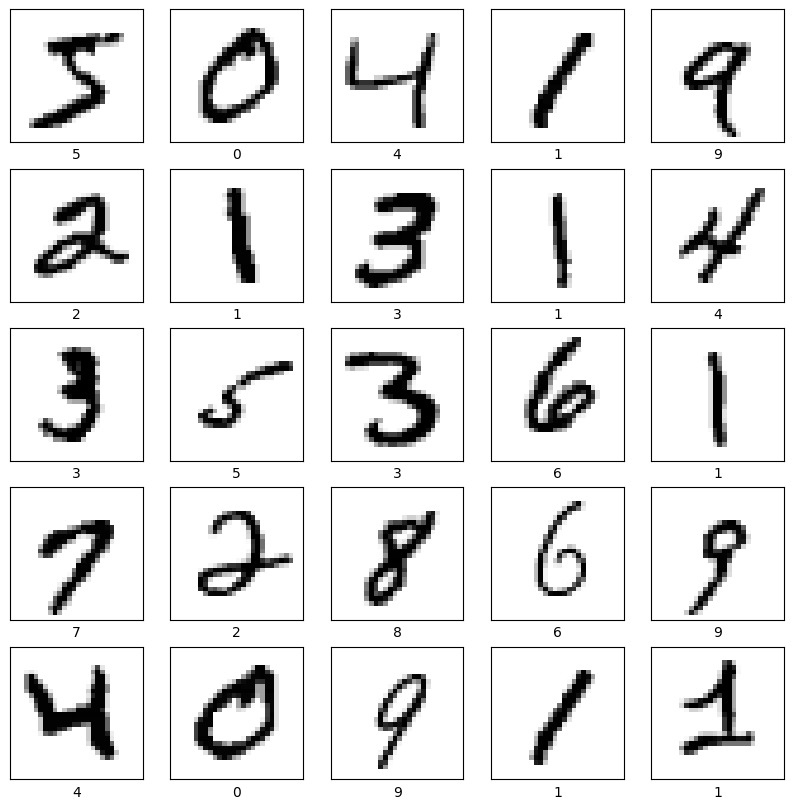

In [16]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reshape the data to include the channel dimension
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Verify the data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(6, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(10))

In [21]:
# Compile the model without specifying the optimizer
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

class MemoryUsageCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        process = psutil.Process(os.getpid())
        memory_info = process.memory_info()
        print(f"\nEpoch {epoch + 1}:")
        print(f"  Memory usage:")
        print(f"    RSS: {memory_info.rss / (1024 ** 2):.2f} MB")
        print(f"    VMS: {memory_info.vms / (1024 ** 2):.2f} MB")
        print()


logdir = "./logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch='500,520')

In [23]:
batch_size = 100
memory_usage_callback = MemoryUsageCallback()
history = model.fit(train_images, train_labels, epochs=3, 
                    batch_size=batch_size,
                    validation_data=(test_images, test_labels),
                    callbacks=[memory_usage_callback])

Epoch 1/3
595/600 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9929
Epoch 1:
  Memory usage:
    RSS: 2376.08 MB
    VMS: 3336.18 MB

600/600 [==============================] - 3s 5ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0358 - val_accuracy: 0.9887
Epoch 2/3
591/600 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9931
Epoch 2:
  Memory usage:
    RSS: 2376.21 MB
    VMS: 3336.31 MB

600/600 [==============================] - 3s 5ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0405 - val_accuracy: 0.9871
Epoch 3/3
595/600 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9941
Epoch 3:
  Memory usage:
    RSS: 2376.34 MB
    VMS: 3336.44 MB

600/600 [==============================] - 3s 5ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0385 - val_accuracy: 0.9868


313/313 - 1s - loss: 0.0385 - accuracy: 0.9868 - 653ms/epoch - 2ms/step
0.9868000149726868


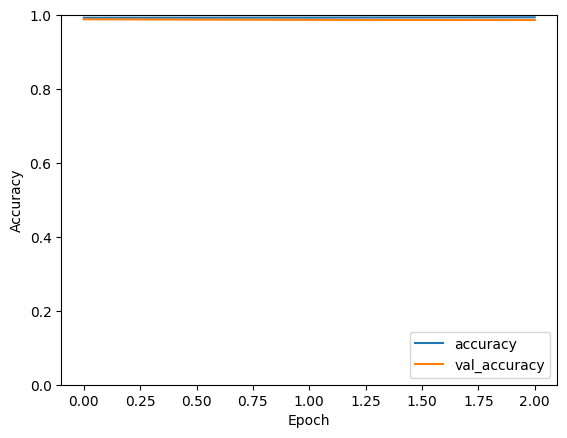

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(test_acc)